In [1]:
import os
import pandas as pd
import numpy as np
import xarray as xr
import json
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial


## Pathing ### ----------------
cesm_forcing_dir = "/glade/campaign/cesm/cesmdata/inputdata/"
nldas_dir = os.path.join(cesm_forcing_dir,
                         "atm/datm7/atm_forcing.datm7.NLDAS2.0.125d.v1")

ppt_dir = os.path.join(nldas_dir, "Precip")
ppt_fns = [os.path.join(ppt_dir, fn) for fn in os.listdir(ppt_dir)]
ppt_fns.sort()

path_to_samples = '../data/monthly_ppt_samples.csv'


### User Settings ### --------
read_in_PRECTmms = True  # Should this script read in all files in ppt_fns and stack into an xarray ds?
extract_samples = True  # Should this script read in the tundra points and sample precip data?

os.listdir(nldas_dir)

['Solar',
 'ctsmforc.NLDAS2.cdf5.0.125d.v1.ESMFmesh_120620_c210330.nc',
 'Precip',
 'README_190425',
 'TPQWL']

## Set up Casper Cluster 

In [2]:
# By default gets 1 core w/ 16 GB memory
def get_ClusterClient(ncores=1, nmem='16GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores = ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        account='P93300641', # Input your project ID here
        walltime='2:30:00', # Amount of wall time
        interface='ext', # Interface to use 'lo' provided a cluster window, below.
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client


# ------------------------------------------------------------------------------------------------------
# Initiate Cluster
# ------------------------------------------------------------------------------------------------------
cluster, client = get_ClusterClient(nmem='8GB')
cluster.scale(20) 
cluster

/glade/u/home/milesmoore/.conda/envs/nwt_clm/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46261 instead
  warnings.warn(


Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/milesmoore/proxy/46261/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.98:33245,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/milesmoore/proxy/46261/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Reading in and processing .nc PRECTmms data

In [3]:
### Define custom helper functions for readable code elsewhere

# ------------------------------------------------------------------------------------------------------
# Function to preprocess each dataset by selecting a region and variable 
# ------------------------------------------------------------------------------------------------------
def _preprocess(ds, lon_bnds, lat_bnds, freq):
    # Adjust coordinates from 0 - 360 lon to regular dd lon to be more intuitive
    ds = ds.assign_coords(longitude=('lon', (360 - ds['LONGXY'].data[0, :]) * -1),
                          latitude=('lat', ds['LATIXY'].data[:, 0])) 

    # Rename old dims to avoid confusion
    ds = ds.rename({'lon': 'x', 'lat': 'y'})  

    # Swamp more intuitive coords into ds coords
    ds = ds.swap_dims({'x': 'longitude', 'y': 'latitude'})

    # Decode times to Climate and Forceast Standards as np datetimen64
    ds['time'] = xr.decode_cf(ds).time
    
    # Subset Dataset for region of interest.
    ds = ds.sel(longitude=slice(*lon_bnds), latitude=slice(*lat_bnds))

    #Compute Monthly Average
    ds = ds.resample({'time':freq}).mean()
    
    return ds


# ------------------------------------------------------------------------------------------------------
# Define a function to read in tundra_pts and build into an xr dataarray 
# ------------------------------------------------------------------------------------------------------

def build_sample_locations():
    # Read in a df of sample locations
    points_df = pd.read_csv("../data/tundra_pts.csv")

    # Extract coordinates from the 'geo' column
    points_df['coordinates'] = points_df['.geo'].apply(lambda x: json.loads(x)['coordinates'])
    points_df['longitude'] = points_df['coordinates'].apply(lambda x: x[0])
    points_df['latitude'] = points_df['coordinates'].apply(lambda x: x[1])


    # Extract the coordinates as numpy arrays
    lons = points_df['longitude'].values
    lats = points_df['latitude'].values

    # Create an xarray.DataArray with the points
    points_da = xr.DataArray(
        np.stack([lons, lats], axis=1),
        dims=['points', 'coords'],
        coords={'points': points_df.index, 'coords': ['lon', 'lat']}
    )

    return points_da

In [4]:
# ------------------------------------------------------------------------------------------------------
# Open all files and preprocess nldas data to optimize memory 
# ------------------------------------------------------------------------------------------------------

# Define bbox and resample frequency
lon_bnds, lat_bnds = (-112, -102), (33, 45)
freq = 'D'  # e.g. ME for Month End, see xarray.cftime_range docs
# Partially define function w lat lon bounds to subset by
partial_func = partial(_preprocess, lon_bnds=lon_bnds, lat_bnds=lat_bnds, freq=freq)


# Reading in and Preprocessing data
print(f'Initializing dataset, clipping to {lon_bnds}, {lat_bnds} and resampling to {freq}...')

ds = xr.open_mfdataset(
    ppt_fns, preprocess=partial_func, data_vars='minimal', parallel=True
).chunk({'time': -1, 'latitude': 5, 'longitude': 5}).persist()

print('Finished loading dataset!')

print(ds)


Initializing dataset, clipping to (-112, -102), (33, 45) and resampling to D...


/glade/u/home/milesmoore/.conda/envs/nwt_clm/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 16.21 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Finished loading dataset!
<xarray.Dataset>
Dimensions:    (time: 14235, latitude: 96, longitude: 80, scalar: 1)
Coordinates:
  * longitude  (longitude) float32 -111.9 -111.8 -111.7 ... -102.3 -102.2 -102.1
  * latitude   (latitude) float32 33.06 33.19 33.31 33.44 ... 44.69 44.81 44.94
  * time       (time) object 1980-01-01 00:00:00 ... 2018-12-31 00:00:00
Dimensions without coordinates: scalar
Data variables:
    LONGXY     (time, latitude, longitude) float32 dask.array<chunksize=(14235, 5, 5), meta=np.ndarray>
    LATIXY     (time, latitude, longitude) float32 dask.array<chunksize=(14235, 5, 5), meta=np.ndarray>
    EDGEE      (time, scalar) float32 dask.array<chunksize=(14235, 1), meta=np.ndarray>
    EDGEW      (time, scalar) float32 dask.array<chunksize=(14235, 1), meta=np.ndarray>
    EDGES      (time, scalar) float32 dask.array<chunksize=(14235, 1), meta=np.ndarray>
    EDGEN      (time, scalar) float32 dask.array<chunksize=(14235, 1), meta=np.ndarray>
    PRECTmms   (time, lati

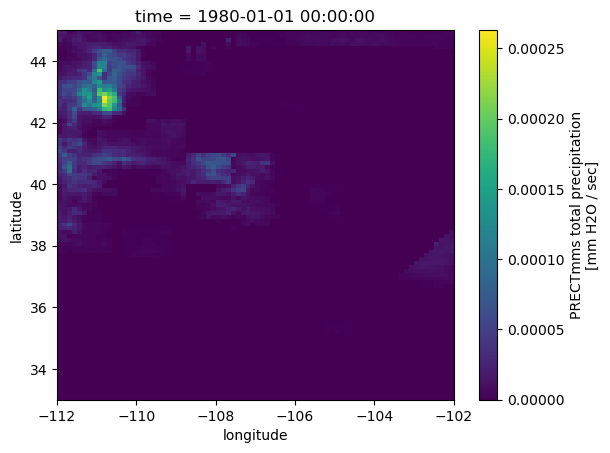

In [5]:
# Plot one timestep from the dataset
ds['PRECTmms'].isel(time=0).plot()

In [6]:
if extract_samples:
    points_da = build_sample_locations()
    sampled_data = ds['PRECTmms'].sel(
        longitude=points_da.sel(coords='lon'),
        latitude=points_da.sel(coords='lat'),
        method='nearest'
    )
    
    # Convert to a DataFrame
    ppt_samples = sampled_data.to_dataframe().reset_index()
    
    # Save sampled data
    ppt_samples.to_csv(path_to_samples, index = False)

## Seasonal Decomposition of Precipitation Trends

In [7]:
# Read in sampled ppt data and parse time column.
ppt_samples = pd.read_csv(path_to_samples)

# Convert 'time' column to datetime
ppt_samples['time'] = pd.to_datetime(ppt_samples['time'])

# Extract year and month from 'time'
ppt_samples['year'] = ppt_samples['time'].dt.year
ppt_samples['month'] = ppt_samples['time'].dt.month

ppt_samples.head()

,time,points,longitude,latitude,PRECTmms,year,month
0,1980-01-01,0,-107.4375,37.9375,0.000000e+00,1980,1
1,1980-01-01,1,-105.9375,40.4375,0.000000e+00,1980,1
2,1980-01-01,2,-106.6875,38.6875,4.116898e-06,1980,1
3,1980-01-01,3,-106.4375,39.4375,9.155092e-07,1980,1
4,1980-01-01,4,-106.4375,39.0625,0.000000e+00,1980,1


<Axes: title={'center': 'Precipitation (mms h2o / sec) Time Series for a Randomly Sampled Point'}, xlabel='time'>

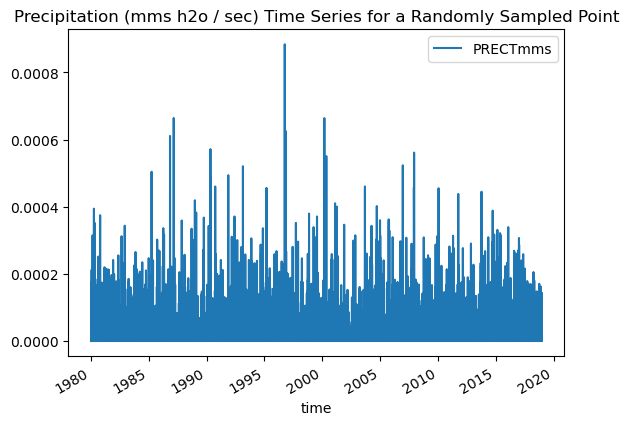

In [8]:
ppt_samples[ppt_samples.points == 0].plot(x='time', y = 'PRECTmms', title = 'Precipitation (mms h2o / sec) Time Series for a Randomly Sampled Point')

In [9]:
# Group by year and month, and calculate the mean precipitation
ppt_samples = ppt_samples.groupby(['year', 'month'])['PRECTmms'].mean().reset_index()

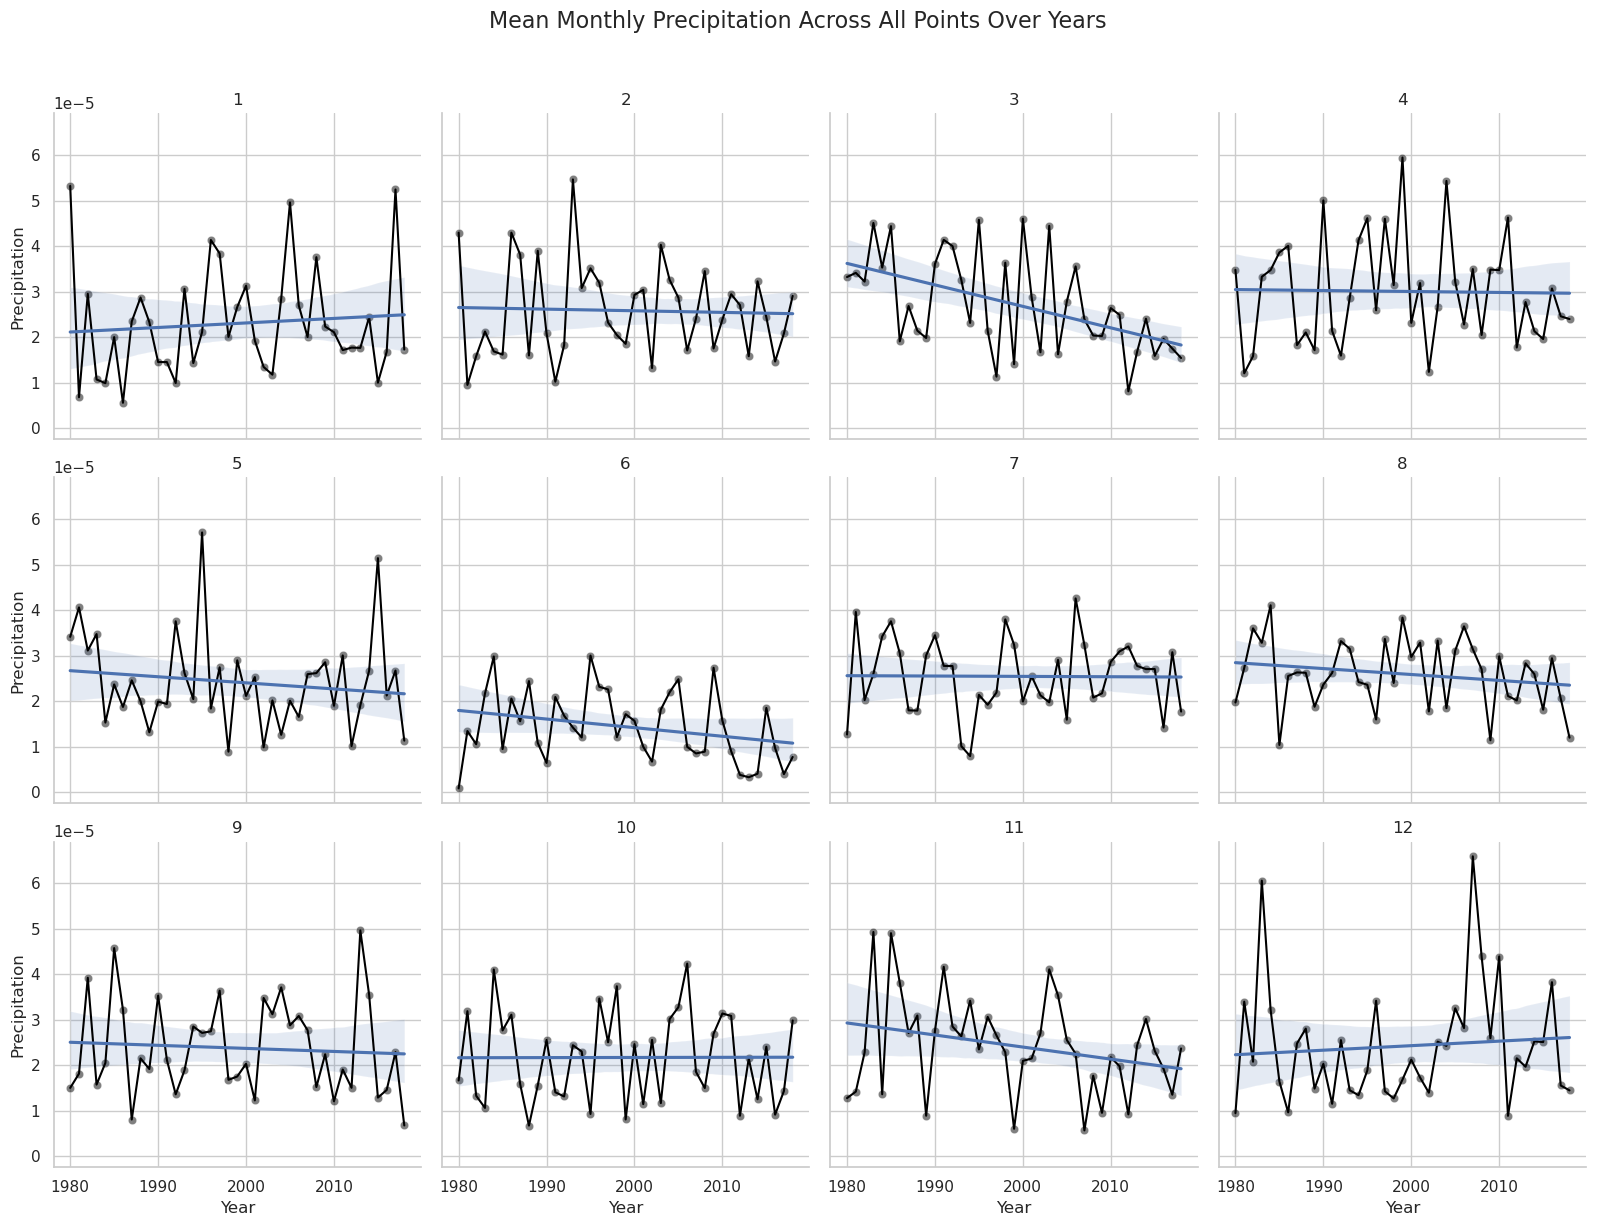

In [10]:
# Set up the plotting environment
sns.set(style='whitegrid')

# Create a facet grid plot
g = sns.FacetGrid(ppt_samples, col='month', col_wrap=4, height=4)

# Add points, lines, and a linear regression smooth line
g.map_dataframe(sns.scatterplot, x='year', y='PRECTmms', color = 'black', alpha=0.5)
g.map_dataframe(sns.lineplot, x='year', y='PRECTmms', color = 'black')
g.map_dataframe(sns.regplot, x='year', y='PRECTmms', scatter=False, order=1)

# Adjust the layout
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Year', 'Precipitation')
g.add_legend()

plt.suptitle('Mean Monthly Precipitation Across All Points Over Years', size=16, y=1.02)

# Show the plot
plt.tight_layout()
plt.show()

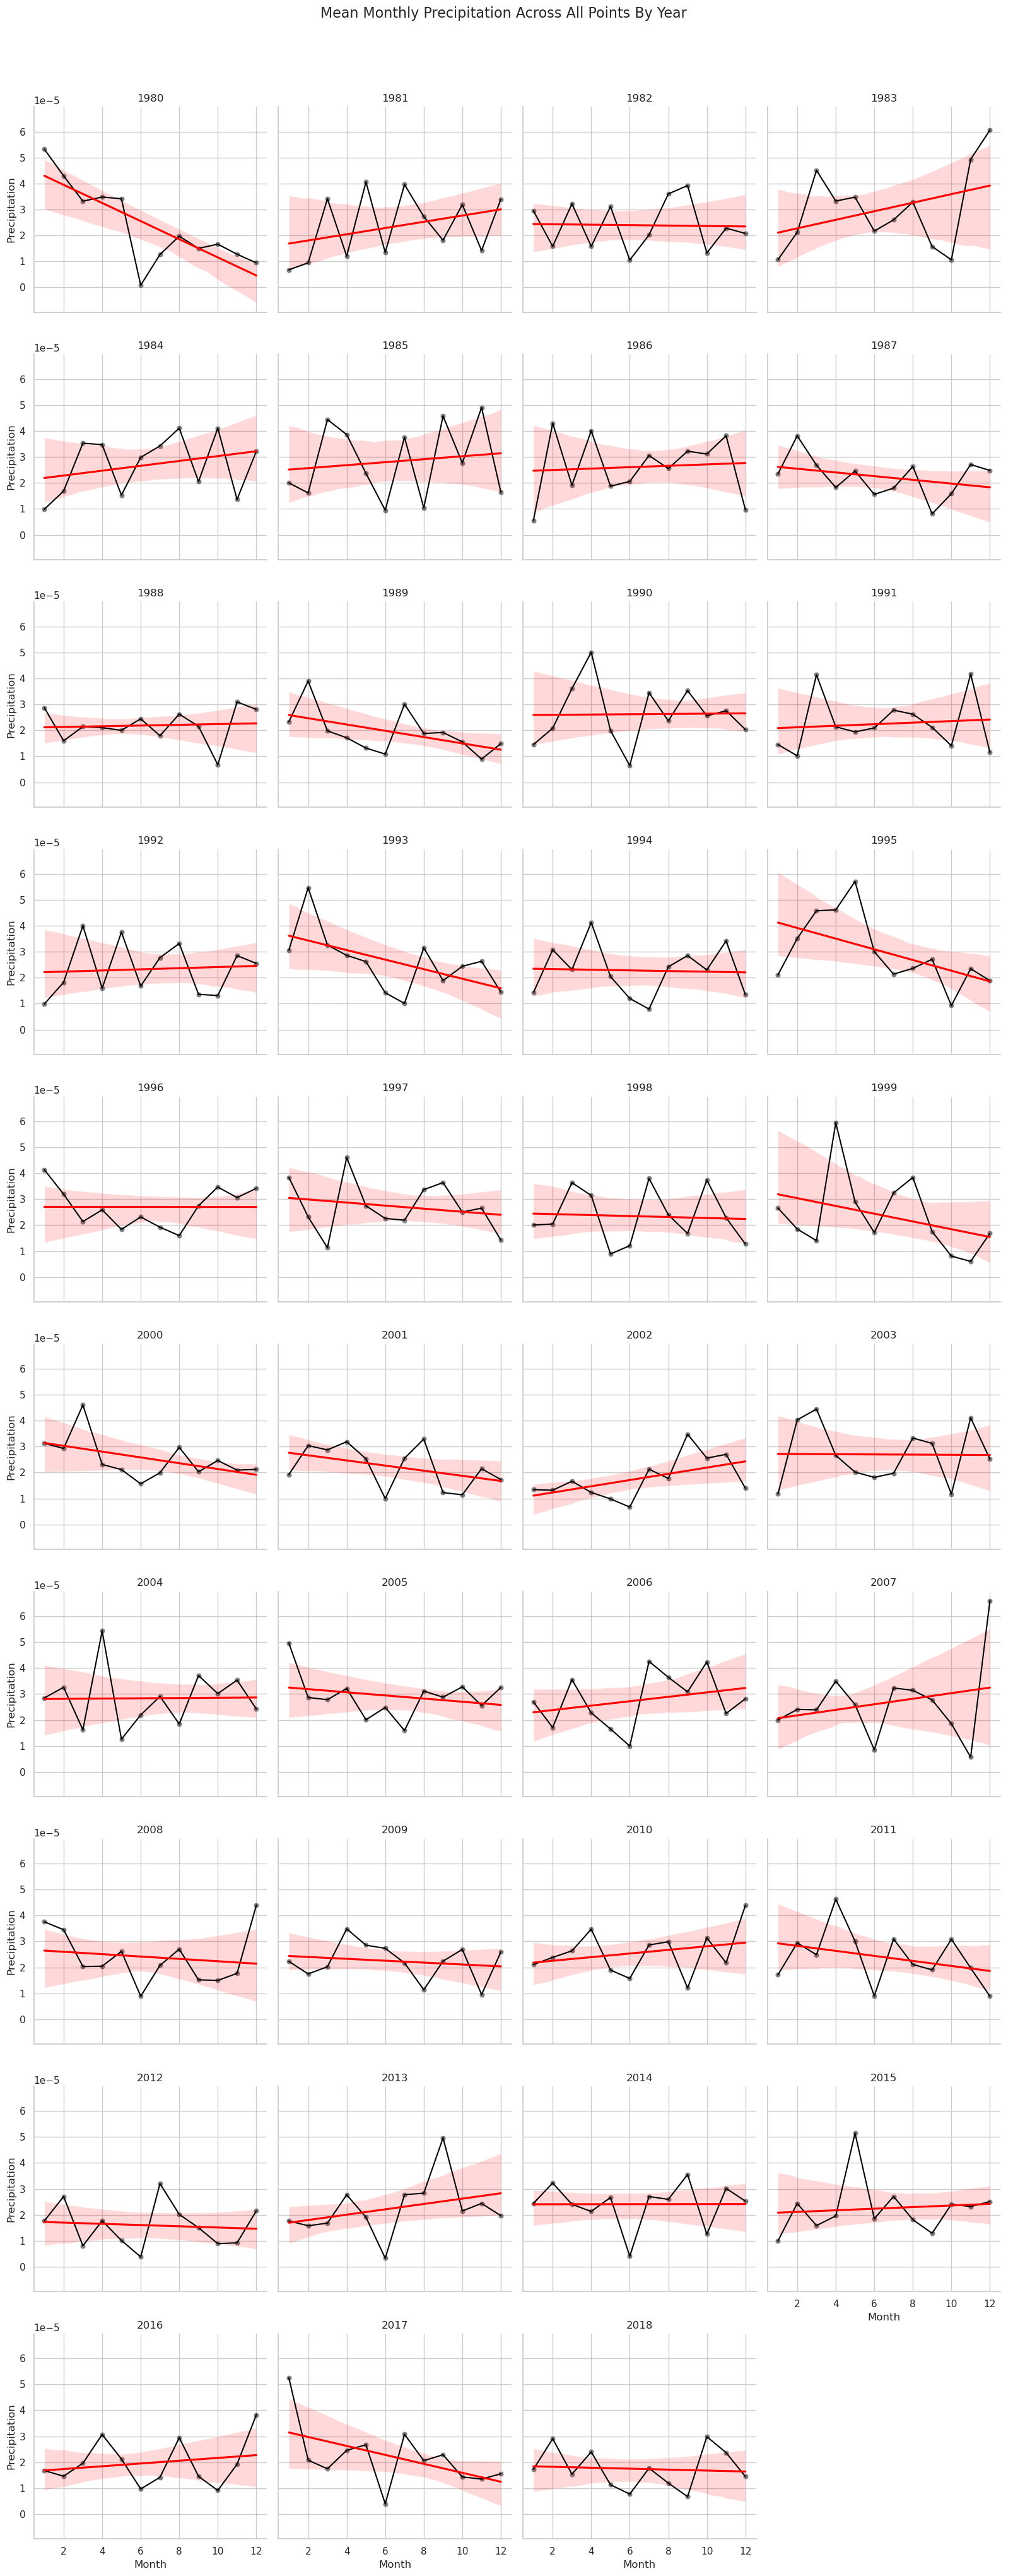

In [11]:
# Set up the plotting environment
sns.set(style='whitegrid')

# Create a facet grid plot
g = sns.FacetGrid(ppt_samples, col='year', col_wrap=4, height=4)

# Add points, lines, and a linear regression smooth line
g.map_dataframe(sns.scatterplot, x='month', y='PRECTmms', color = 'black', alpha=0.5)
g.map_dataframe(sns.lineplot, x='month', y='PRECTmms', color = 'black')
g.map_dataframe(sns.regplot, x='month', y='PRECTmms', color = 'red', scatter=False, order=1)

# Adjust the layout
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Month', 'Precipitation')
g.add_legend()

plt.suptitle('Mean Monthly Precipitation Across All Points By Year', size=16, y=1.02)

# Show the plot
plt.tight_layout()
plt.show()

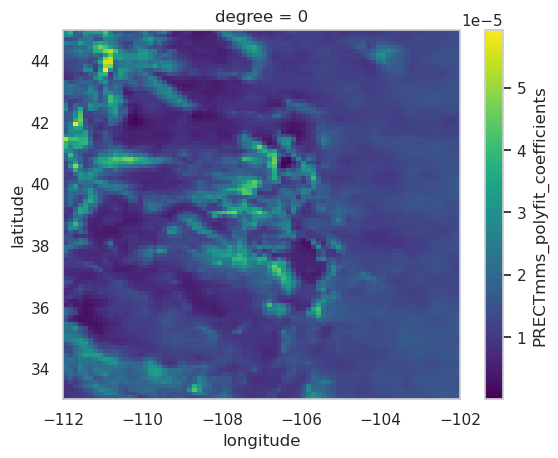

In [12]:
# Plot the trends and mean precipitation across space.
trends_coeffs = ds.polyfit(dim = "time", deg = 1)

# Intercepts
trends_coeffs['PRECTmms_polyfit_coefficients'].sel(degree = 0).plot()

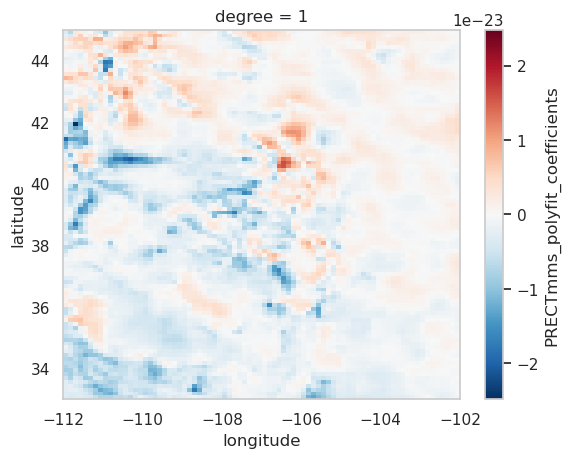

In [13]:
# Slopes
trends_coeffs['PRECTmms_polyfit_coefficients'].sel(degree = 1).plot()